In [ ]:
# When running for the first time, run in terminal to set up the environment:
    # Set-ExecutionPolicy -ExecutionPolicy Bypass -Scope Process    
    # python -m venv env    
    # .\env\Scripts\activate
    # pip install -r requirements.txt

# Import libraries

In [35]:
import os
import glob
import soundfile as sf
import torch
import pandas as pd
from audiobox_aesthetics.infer import initialize_predictor
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Meta: Audio Aesthetics

In [36]:
def main():
    audio_dir = r"C:\GitHub\audio-aesthetics\assets"
    audio_files = glob.glob(os.path.join(audio_dir, "*.wav")) + glob.glob(os.path.join(audio_dir, "*.mp3"))
    
    predictor = initialize_predictor()
    
    batch_data = []
    for fpath in audio_files:
        data, sr = sf.read(fpath)
        audio_tensor = torch.tensor(data, dtype=torch.float32).T
        batch_data.append({"path": audio_tensor, "sample_rate": sr, "filename": fpath})
    
    # Forward pass over all files
    predictions = predictor.forward(batch_data)
    
    results = []
    for pred, info in zip(predictions, batch_data):
        ce_val = pred.get("CE", None)
        cu_val = pred.get("CU", None)
        pc_val = pred.get("PC", None)
        pq_val = pred.get("PQ", None)
        
        file_name = os.path.basename(info["filename"])
        results.append([
            file_name,
            ce_val,
            cu_val,
            pc_val,
            pq_val
        ])
    
    # Rename columns in the final DataFrame
    df_scores = pd.DataFrame(results, columns=[
        "file",
        "content-enjoyment",
        "content-usefulness",
        "production-complexity",
        "production-quality"
    ])
    print(df_scores)
    df_scores.to_csv("results/aesthetics_results.csv", index=False)

    return df_scores  # <-- return it so it's accessible

if __name__ == "__main__":
    df_scores = main()


c:\GitHub\audio-aesthetics\env\lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
c:\GitHub\audio-aesthetics\env\lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


                             file  content-enjoyment  content-usefulness  \
0                 lineare_a2a.wav           7.297026            7.631387   
1                 lineare_ace.wav           5.886321            6.453405   
2          lineare_fiorentini.wav           7.197011            7.041038   
3            lineare_garofalo.wav           6.113775            4.880628   
4   lineare_hai-assicurazione.wav           5.740927            6.343976   
5            lineare_postepay.wav           6.809984            6.938411   
6             lineare_seresto.wav           5.346477            4.627346   
7              lineare_suzuki.wav           5.964487            4.844994   
8            playlist_bernina.mp3           6.759501            5.221873   
9            playlist_citroen.mp3           5.785450            6.332827   
10           playlist_melinda.mp3           6.228623            6.047773   
11   playlist_natural-trainer.mp3           6.344067            5.609169   
12       pla

# Audio feature extraction

## Loudness

In [77]:
import os
import glob
import numpy as np
import librosa
import pandas as pd

def compute_weighted_loudness(y, sr, segment_ms=100):
    frame_length = int(sr * segment_ms / 1000)
    hop_length = frame_length

    S = np.abs(librosa.stft(y, n_fft=frame_length, hop_length=hop_length))
    freqs = librosa.fft_frequencies(sr=sr, n_fft=frame_length)

    def auditory_weight(freqs):
        return 1 / (1 + (freqs / 1000)**4)

    eta = auditory_weight(freqs).reshape(-1, 1)
    weighted_sum = np.sum(S * eta, axis=0)
    loudness = np.log10(weighted_sum + 1e-10)
    mean_loudness = np.mean(loudness)

    return mean_loudness

# Directory and files
audio_dir = r"C:\GitHub\audio-aesthetics\assets"
audio_files = glob.glob(os.path.join(audio_dir, "*.wav")) + glob.glob(os.path.join(audio_dir, "*.mp3"))

results = []

for fpath in audio_files:
    try:
        y, sr = librosa.load(fpath, sr=None)
        mean_loudness = compute_weighted_loudness(y, sr)
        results.append({"filename": os.path.basename(fpath), "mean_loudness": mean_loudness})
    except Exception as e:
        print(f"Error processing {fpath}: {e}")

# Create DataFrame of results
df_loudness = pd.DataFrame(results)
print(df_loudness)


                         filename  mean_loudness
0                 lineare_a2a.wav       2.747069
1                 lineare_ace.wav       2.538434
2          lineare_fiorentini.wav       2.854011
3            lineare_garofalo.wav       2.816120
4   lineare_hai-assicurazione.wav       2.591636
5            lineare_postepay.wav       2.890366
6             lineare_seresto.wav       2.827580
7              lineare_suzuki.wav       2.811300
8            playlist_bernina.mp3       3.010312
9            playlist_citroen.mp3       3.036602
10           playlist_melinda.mp3       3.025496
11   playlist_natural-trainer.mp3       3.219994
12       playlist_parmareggio.mp3       3.159835
13           playlist_repower.mp3       3.008683
14          playlist_tenderly.mp3       2.955702
15         playlist_valfrutta.mp3       3.088660
16            playlist_yakult.mp3       3.091181


## Onset density

In [78]:
import os
import glob
import numpy as np
import librosa
import pandas as pd

def compute_onset_density(y, sr):
    # Detect onset frames
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
    
    # Convert frames to times (in seconds)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    
    # Duration of the audio
    duration = librosa.get_duration(y=y, sr=sr)
    
    # Onset density: number of onsets per second
    density = len(onset_times) / duration if duration > 0 else np.nan
    
    return density

# Directory and files
audio_dir = r"C:\GitHub\audio-aesthetics\assets"
audio_files = glob.glob(os.path.join(audio_dir, "*.wav")) + glob.glob(os.path.join(audio_dir, "*.mp3"))

results = []

for fpath in audio_files:
    try:
        y, sr = librosa.load(fpath, sr=None)
        onset_density = compute_onset_density(y, sr)
        results.append({"filename": os.path.basename(fpath), "onset_density": onset_density})
    except Exception as e:
        print(f"Error processing {fpath}: {e}")

# Create DataFrame of results
df_onsets = pd.DataFrame(results)
print(df_onsets)


                         filename  onset_density
0                 lineare_a2a.wav       4.185830
1                 lineare_ace.wav       3.811779
2          lineare_fiorentini.wav       5.306762
3            lineare_garofalo.wav       5.178824
4   lineare_hai-assicurazione.wav       5.009077
5            lineare_postepay.wav       6.351881
6             lineare_seresto.wav       7.527458
7              lineare_suzuki.wav       3.551490
8            playlist_bernina.mp3       6.289832
9            playlist_citroen.mp3       6.672143
10           playlist_melinda.mp3       7.004943
11   playlist_natural-trainer.mp3       6.391860
12       playlist_parmareggio.mp3       5.315018
13           playlist_repower.mp3       5.751595
14          playlist_tenderly.mp3       6.090122
15         playlist_valfrutta.mp3       4.676286
16            playlist_yakult.mp3       6.243970


## Timbre centroid

In [79]:
import os
import glob
import numpy as np
import librosa
import pandas as pd

def compute_global_centroid(y, sr):
    # Compute spectral centroid over time
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    
    # Average over all frames
    global_centroid = np.mean(centroid)
    
    return global_centroid

# Directory and files
audio_dir = r"C:\GitHub\audio-aesthetics\assets"
audio_files = glob.glob(os.path.join(audio_dir, "*.wav")) + glob.glob(os.path.join(audio_dir, "*.mp3"))

results = []

for fpath in audio_files:
    try:
        y, sr = librosa.load(fpath, sr=None)
        centroid = compute_global_centroid(y, sr)
        results.append({"filename": os.path.basename(fpath), "timbre_centroid_hz": centroid})
    except Exception as e:
        print(f"Error processing {fpath}: {e}")

# Create DataFrame of results
df_centroid = pd.DataFrame(results)
print(df_centroid)


                         filename  timbre_centroid_hz
0                 lineare_a2a.wav         3889.081619
1                 lineare_ace.wav         3861.121980
2          lineare_fiorentini.wav         2401.528242
3            lineare_garofalo.wav         2867.524272
4   lineare_hai-assicurazione.wav         4821.089806
5            lineare_postepay.wav         2935.337650
6             lineare_seresto.wav         2953.619988
7              lineare_suzuki.wav         3307.594208
8            playlist_bernina.mp3         2014.353059
9            playlist_citroen.mp3         3906.635143
10           playlist_melinda.mp3         3338.365930
11   playlist_natural-trainer.mp3         2809.505929
12       playlist_parmareggio.mp3         2731.096261
13           playlist_repower.mp3         3887.921327
14          playlist_tenderly.mp3         2183.793324
15         playlist_valfrutta.mp3         3114.174261
16            playlist_yakult.mp3         3494.224714


# Aggregated dataframe setup

In [37]:
# Function to extract mode and brand
def extract_mode_brand(filename):
    base = os.path.splitext(filename)[0]  # remove extension
    parts = base.split('_')
    mode = parts[0] if len(parts) > 0 else None
    brand = parts[1] if len(parts) > 1 else None
    return mode, brand

# Apply extraction
df_scores[['mode', 'brand']] = df_scores['file'].apply(lambda x: pd.Series(extract_mode_brand(x)))

# Reorder columns: keep File first, then mode and brand, then all remaining columns
cols = ['file', 'mode', 'brand'] + [col for col in df_scores.columns if col not in ['file', 'mode', 'brand']]
df_scores = df_scores[cols]

# Display result
print(df_scores)

                             file      mode              brand  \
0                 lineare_a2a.wav   lineare                a2a   
1                 lineare_ace.wav   lineare                ace   
2          lineare_fiorentini.wav   lineare         fiorentini   
3            lineare_garofalo.wav   lineare           garofalo   
4   lineare_hai-assicurazione.wav   lineare  hai-assicurazione   
5            lineare_postepay.wav   lineare           postepay   
6             lineare_seresto.wav   lineare            seresto   
7              lineare_suzuki.wav   lineare             suzuki   
8            playlist_bernina.mp3  playlist            bernina   
9            playlist_citroen.mp3  playlist            citroen   
10           playlist_melinda.mp3  playlist            melinda   
11   playlist_natural-trainer.mp3  playlist    natural-trainer   
12       playlist_parmareggio.mp3  playlist        parmareggio   
13           playlist_repower.mp3  playlist            repower   
14        

In [38]:
# Define the allowed brands
allowed_brands = ['repower', 'citroen', 'bernina', 'tenderly']

# Apply the exclusion logic
df_scores['exclude_flag'] = (
    (df_scores['mode'] == 'playlist') & (~df_scores['brand'].isin(allowed_brands))
).astype(int)

# Reorder columns: File, mode, brand, exclude_flag, then the rest
cols = ['file', 'mode', 'brand', 'exclude_flag'] + [
    col for col in df_scores.columns if col not in ['file', 'mode', 'brand', 'exclude_flag']
]
df_scores = df_scores[cols]

# Display result
print(df_scores)


                             file      mode              brand  exclude_flag  \
0                 lineare_a2a.wav   lineare                a2a             0   
1                 lineare_ace.wav   lineare                ace             0   
2          lineare_fiorentini.wav   lineare         fiorentini             0   
3            lineare_garofalo.wav   lineare           garofalo             0   
4   lineare_hai-assicurazione.wav   lineare  hai-assicurazione             0   
5            lineare_postepay.wav   lineare           postepay             0   
6             lineare_seresto.wav   lineare            seresto             0   
7              lineare_suzuki.wav   lineare             suzuki             0   
8            playlist_bernina.mp3  playlist            bernina             0   
9            playlist_citroen.mp3  playlist            citroen             0   
10           playlist_melinda.mp3  playlist            melinda             1   
11   playlist_natural-trainer.mp3  playl

In [39]:
# Import the table
df_recall = pd.read_excel(r"C:\GitHub\audio-aesthetics\tables\table_recall.xlsx")

# Group by 'brand' and 'condition' and calculate ratios
df_recall_aggregated = df_recall.groupby(['brand', 'condition', 'mode']).agg({
    'unaided': lambda x: x.sum() / x.count(),
    'aided': lambda x: x.sum() / x.count()
}).reset_index()

print(df_recall_aggregated)

                brand  condition      mode   unaided     aided
0                 a2a  demanding    linear  0.225000  0.275000
1                 a2a    relaxed    linear  0.257143  0.342857
2                 ace  demanding    linear  0.075000  0.075000
3                 ace    relaxed    linear  0.114286  0.228571
4             bernina  demanding  playlist  0.055556  0.166667
5             bernina    relaxed  playlist  0.075000  0.125000
6             citroen  demanding  playlist  0.111111  0.166667
7             citroen    relaxed  playlist  0.125000  0.175000
8          fiorentini  demanding    linear  0.025000  0.100000
9          fiorentini    relaxed    linear  0.057143  0.314286
10           garofalo  demanding    linear  0.100000  0.150000
11           garofalo    relaxed    linear  0.171429  0.285714
12  hai-assicurazione  demanding    linear  0.000000  0.000000
13  hai-assicurazione    relaxed    linear  0.028571  0.028571
14            melinda  demanding  playlist  0.027778  0

In [40]:
# Subset df_scores where exclude_flag == 0
df = df_recall_aggregated

# Create mapping dictionaries from df_scores
exclude_flag_dict = df_scores.set_index('brand')['exclude_flag'].to_dict()
content_enjoyment_dict = df_scores.set_index('brand')['content-enjoyment'].to_dict()
content_usefulness_dict = df_scores.set_index('brand')['content-usefulness'].to_dict()
production_complexity_dict = df_scores.set_index('brand')['production-complexity'].to_dict()
production_quality_dict = df_scores.set_index('brand')['production-quality'].to_dict()

# Map the values into df
df['exclude_flag'] = df['brand'].map(exclude_flag_dict)
df['content-enjoyment'] = df['brand'].map(content_enjoyment_dict)
df['content-usefulness'] = df['brand'].map(content_usefulness_dict)
df['production-complexity'] = df['brand'].map(production_complexity_dict)
df['production-quality'] = df['brand'].map(production_quality_dict)

df['is-demanding'] = (df['condition'] == 'demanding').astype(int)
df['is-playlist'] = (df['mode'] == 'playlist').astype(int)
df['is-invented-brand'] = df['brand'].isin(['hai-assicurazione', 'bernina']).astype(int)

# Get current columns
cols = list(df.columns)

# Move 'unaided' and 'aided' to the end
cols = [col for col in cols if col not in ['unaided', 'aided']] + ['unaided', 'aided']

# Reorder dataframe
df = df[cols]

# Display result
print(df)



                brand  condition      mode  exclude_flag  content-enjoyment  \
0                 a2a  demanding    linear             0           7.297026   
1                 a2a    relaxed    linear             0           7.297026   
2                 ace  demanding    linear             0           5.886321   
3                 ace    relaxed    linear             0           5.886321   
4             bernina  demanding  playlist             0           6.759501   
5             bernina    relaxed  playlist             0           6.759501   
6             citroen  demanding  playlist             0           5.785450   
7             citroen    relaxed  playlist             0           5.785450   
8          fiorentini  demanding    linear             0           7.197011   
9          fiorentini    relaxed    linear             0           7.197011   
10           garofalo  demanding    linear             0           6.113775   
11           garofalo    relaxed    linear          

# Granular dataframe setup

In [43]:
df_granular = df_recall

In [49]:
# Define the allowed brands
allowed_brands = ['repower', 'citroen', 'bernina', 'tenderly']

# Apply the exclusion logic
df_granular['exclude_flag'] = (
    (df_granular['mode'] == 'playlist') & (~df_granular['brand'].isin(allowed_brands))
).astype(int)

print(df_granular)

     id-participant              brand      mode condition  knew-the-ad  \
0               s01                a2a    linear   relaxed            0   
1               s01                ace    linear   relaxed            0   
2               s01         fiorentini    linear   relaxed            0   
3               s01           garofalo    linear   relaxed            0   
4               s01  hai-assicurazione    linear   relaxed            0   
...             ...                ...       ...       ...          ...   
1279            s88        parmareggio  playlist   relaxed            0   
1280            s88            repower  playlist   relaxed            0   
1281            s88           tenderly  playlist   relaxed            0   
1282            s88          valfrutta  playlist   relaxed            0   
1283            s88             yakult  playlist   relaxed            0   

      unaided  aided  exclude_flag  
0           0      0             0  
1           0      1     

In [51]:
# Create mapping dictionaries from df_scores
content_enjoyment_dict = df_scores.set_index('brand')['content-enjoyment'].to_dict()
content_usefulness_dict = df_scores.set_index('brand')['content-usefulness'].to_dict()
production_complexity_dict = df_scores.set_index('brand')['production-complexity'].to_dict()
production_quality_dict = df_scores.set_index('brand')['production-quality'].to_dict()

# Map the values into df
df_granular['content-enjoyment'] = df_granular['brand'].map(content_enjoyment_dict)
df_granular['content-usefulness'] = df_granular['brand'].map(content_usefulness_dict)
df_granular['production-complexity'] = df_granular['brand'].map(production_complexity_dict)
df_granular['production-quality'] = df_granular['brand'].map(production_quality_dict)

df_granular['is-demanding'] = (df_granular['condition'] == 'demanding').astype(int)
df_granular['is-playlist'] = (df_granular['mode'] == 'playlist').astype(int)
df_granular['is-invented-brand'] = df_granular['brand'].isin(['hai-assicurazione', 'bernina']).astype(int)


In [53]:
# Remove records where exclude_flag is 1
df_granular = df_granular[df_granular['exclude_flag'] != 1].copy()

# Drop the exclude_flag variable
df_granular.drop(columns='exclude_flag', inplace=True)

In [54]:
df_granular

,id-participant,brand,mode,condition,knew-the-ad,unaided,aided,content-enjoyment,content-usefulness,production-complexity,production-quality,is-demanding,is-playlist,is-invented-brand
0,s01,a2a,linear,relaxed,0,0,0,7.297026,7.631387,7.103478,8.231108,0,0,0
1,s01,ace,linear,relaxed,0,0,1,5.886321,6.453405,4.109528,7.966639,0,0,0
2,s01,fiorentini,linear,relaxed,0,0,0,7.197011,7.041038,6.490301,8.217696,0,0,0
3,s01,garofalo,linear,relaxed,0,0,0,6.113775,4.880628,6.430488,7.392758,0,0,0
4,s01,hai-assicurazione,linear,relaxed,0,0,0,5.740927,6.343976,1.918679,7.670848,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,s88,suzuki,linear,demanding,0,1,1,5.964487,4.844994,6.514189,7.199000,1,0,0
1275,s88,bernina,playlist,relaxed,0,0,0,6.759501,5.221873,6.496495,7.747781,0,1,1
1276,s88,citroen,playlist,relaxed,0,0,0,5.785450,6.332827,5.257134,7.861231,0,1,0
1280,s88,repower,playlist,relaxed,0,0,0,6.305100,5.676331,6.908421,7.500104,0,1,0


# Semantic analysis

In [17]:
# Load the Excel file into a DataFrame
df_liwc = pd.read_excel(r"C:\GitHub\audio-aesthetics\tables\table_results_liwc.xlsx")

# Optional: Display the first few rows
print(df_liwc.head())

        brand                                            copy_it  \
0  fiorentini  Ci vuole Fiorentini, le gallette e gli snacchi...   
1         a2a  A2A, …2A, …2A! Ti da energia da acqua, sole e ...   
2     citroen  Amore, che dici finalmente cambiamo l’auto? Ma...   
3    garofalo  L'amore, quello vero, ti fa sentire le farfall...   
4    tenderly  Ehi i grandi! Abbiamo un messaggio importante....   

                                             copy_en  wc_it  \
0  You need Fiorentini, crackers and snacks. Hey ...     41   
1  A2A, …2A, …2A! It gives you energy from water,...     33   
2  Honey, what do you say—should we finally chang...     58   
3  True love gives you butterflies in your stomac...     32   
4  Hey grown-ups! We've got an important message....     22   

   analytical_thinking  
0                 7.14  
1                34.33  
2                46.42  
3                55.25  
4                72.44  


In [20]:
# Create mapping dictionaries from df_liwc
analytical_map = df_liwc.set_index('brand')['analytical_thinking'].to_dict()
wordcount_map = df_liwc.set_index('brand')['wc_it'].to_dict()

# Assign new columns using .loc to avoid SettingWithCopyWarning
df.loc[:, 'liwc_analytical-thinking'] = df['brand'].map(analytical_map)
df.loc[:, 'liwc_word-count'] = df['brand'].map(wordcount_map)

In [22]:
# Identify all columns except 'unaided' and 'aided'
other_columns = [col for col in df.columns if col not in ['unaided', 'aided']]

# Define new column order
new_order = other_columns + ['unaided', 'aided']

# Reorder the DataFrame
df = df[new_order]

In [30]:
# Filter out excluded records
df_filtered = df[df['exclude_flag'] != 1].copy()

# Define independent variable (X) and dependent variable (y)
X = df_filtered[['liwc_analytical-thinking',]]
y = df_filtered['aided']

# Add constant to X for the intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  aided   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     8.040
Date:                Wed, 11 Jun 2025   Prob (F-statistic):            0.00963
Time:                        15:33:50   Log-Likelihood:                 26.113
No. Observations:                  24   AIC:                            -48.23
Df Residuals:                      22   BIC:                            -45.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

# Model finder

In [85]:
import pandas as pd
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# Create interaction terms
df_filtered['content-enjoyment:content-usefulness'] = df_filtered['content-enjoyment'] * df_filtered['content-usefulness']
df_filtered['content-enjoyment:production-complexity'] = df_filtered['content-enjoyment'] * df_filtered['production-complexity']
df_filtered['content-enjoyment:production-quality'] = df_filtered['content-enjoyment'] * df_filtered['production-quality']
df_filtered['content-usefulness:production-complexity'] = df_filtered['content-usefulness'] * df_filtered['production-complexity']
df_filtered['content-usefulness:production-quality'] = df_filtered['content-usefulness'] * df_filtered['production-quality']
df_filtered['production-complexity:production-quality'] = df_filtered['production-complexity'] * df_filtered['production-quality']

df_filtered['content-enjoyment:content-usefulness:production-complexity'] = (
    df_filtered['content-enjoyment'] * df_filtered['content-usefulness'] * df_filtered['production-complexity']
)
df_filtered['content-enjoyment:content-usefulness:production-quality'] = (
    df_filtered['content-enjoyment'] * df_filtered['content-usefulness'] * df_filtered['production-quality']
)
df_filtered['content-enjoyment:production-complexity:production-quality'] = (
    df_filtered['content-enjoyment'] * df_filtered['production-complexity'] * df_filtered['production-quality']
)
df_filtered['content-usefulness:production-complexity:production-quality'] = (
    df_filtered['content-usefulness'] * df_filtered['production-complexity'] * df_filtered['production-quality']
)

df_filtered['content-enjoyment:content-usefulness:production-complexity:production-quality'] = (
    df_filtered['content-enjoyment'] * df_filtered['content-usefulness'] *
    df_filtered['production-complexity'] * df_filtered['production-quality']
)


# --- ASSUME df IS PRELOADED AND CLEAN ---
# Example: df = pd.read_csv("your_data.csv")

# --- CONSTANTS ---
base_filter = (df["exclude_flag"] != 1)

# Named individual conditions
conditions = {
    "is-invented-brand": (df["is-invented-brand"] != 1),
}

# --- Custom list of IV combinations to test ---
custom_var_combos = [
    ('content-enjoyment:content-usefulness', 'content-enjoyment', 'content-usefulness'),
    ('content-enjoyment:production-complexity', 'content-enjoyment', 'production-complexity'),
    ('content-enjoyment:production-quality', 'content-enjoyment', 'production-quality'),
    ('content-usefulness:production-complexity', 'content-usefulness', 'production-complexity'),
    ('content-usefulness:production-quality', 'content-usefulness', 'production-quality'),
    ('production-complexity:production-quality', 'production-complexity', 'production-quality'),
    ('content-enjoyment:content-usefulness:production-complexity', 'content-enjoyment', 'content-usefulness', 'production-complexity'),
    ('content-enjoyment:content-usefulness:production-quality', 'content-enjoyment', 'content-usefulness', 'production-quality'),
    ('content-enjoyment:production-complexity:production-quality', 'content-enjoyment', 'production-complexity', 'production-quality'),
    ('content-usefulness:production-complexity:production-quality', 'content-usefulness', 'production-complexity', 'production-quality'),
    ('content-enjoyment:content-usefulness:production-complexity:production-quality', 'content-enjoyment', 'content-usefulness', 'production-complexity', 'production-quality'),
    ('content-enjoyment', 'content-enjoyment'),
    ('content-usefulness', 'content-usefulness'),
    ('production-complexity', 'production-complexity'),
    ('production-quality', 'production-quality'),
    ('content-enjoyment:content-usefulness', 'content-enjoyment', 'content-usefulness', 'is-demanding'),
    ('content-enjoyment:production-complexity', 'content-enjoyment', 'production-complexity', 'is-demanding'),
    ('content-enjoyment:production-quality', 'content-enjoyment', 'production-quality', 'is-demanding'),
    ('content-usefulness:production-complexity', 'content-usefulness', 'production-complexity', 'is-demanding'),
    ('content-usefulness:production-quality', 'content-usefulness', 'production-quality', 'is-demanding'),
    ('production-complexity:production-quality', 'production-complexity', 'production-quality', 'is-demanding'),
    ('content-enjoyment:content-usefulness:production-complexity', 'content-enjoyment', 'content-usefulness', 'production-complexity', 'is-demanding'),
    ('content-enjoyment:content-usefulness:production-quality', 'content-enjoyment', 'content-usefulness', 'production-quality', 'is-demanding'),
    ('content-enjoyment:production-complexity:production-quality', 'content-enjoyment', 'production-complexity', 'production-quality', 'is-demanding'),
    ('content-usefulness:production-complexity:production-quality', 'content-usefulness', 'production-complexity', 'production-quality', 'is-demanding'),
    ('content-enjoyment:content-usefulness:production-complexity:production-quality', 'content-enjoyment', 'content-usefulness', 'production-complexity', 'production-quality', 'is-demanding'),
    ('content-enjoyment', 'content-enjoyment', 'is-demanding'),
    ('content-usefulness', 'content-usefulness', 'is-demanding'),
    ('production-complexity', 'production-complexity', 'is-demanding'),
    ('production-quality', 'production-quality', 'is-demanding'),
    ('content-enjoyment:content-usefulness', 'content-enjoyment', 'content-usefulness', 'is-playlist'),
    ('content-enjoyment:production-complexity', 'content-enjoyment', 'production-complexity', 'is-playlist'),
    ('content-enjoyment:production-quality', 'content-enjoyment', 'production-quality', 'is-playlist'),
    ('content-usefulness:production-complexity', 'content-usefulness', 'production-complexity', 'is-playlist'),
    ('content-usefulness:production-quality', 'content-usefulness', 'production-quality', 'is-playlist'),
    ('production-complexity:production-quality', 'production-complexity', 'production-quality', 'is-playlist'),
    ('content-enjoyment:content-usefulness:production-complexity', 'content-enjoyment', 'content-usefulness', 'production-complexity', 'is-playlist'),
    ('content-enjoyment:content-usefulness:production-quality', 'content-enjoyment', 'content-usefulness', 'production-quality', 'is-playlist'),
    ('content-enjoyment:production-complexity:production-quality', 'content-enjoyment', 'production-complexity', 'production-quality', 'is-playlist'),
    ('content-usefulness:production-complexity:production-quality', 'content-usefulness', 'production-complexity', 'production-quality', 'is-playlist'),
    ('content-enjoyment:content-usefulness:production-complexity:production-quality', 'content-enjoyment', 'content-usefulness', 'production-complexity', 'production-quality', 'is-playlist'),
    ('content-enjoyment', 'content-enjoyment', 'is-playlist'),
    ('content-usefulness', 'content-usefulness', 'is-playlist'),
    ('production-complexity', 'production-complexity', 'is-playlist'),
    ('production-quality', 'production-quality', 'is-playlist'),
    ('content-enjoyment:content-usefulness', 'content-enjoyment', 'content-usefulness', 'is-demanding', 'is-playlist'),
    ('content-enjoyment:production-complexity', 'content-enjoyment', 'production-complexity', 'is-demanding', 'is-playlist'),
    ('content-enjoyment:production-quality', 'content-enjoyment', 'production-quality', 'is-demanding', 'is-playlist'),
    ('content-usefulness:production-complexity', 'content-usefulness', 'production-complexity', 'is-demanding', 'is-playlist'),
    ('content-usefulness:production-quality', 'content-usefulness', 'production-quality', 'is-demanding', 'is-playlist'),
    ('production-complexity:production-quality', 'production-complexity', 'production-quality', 'is-demanding', 'is-playlist'),
    ('content-enjoyment:content-usefulness:production-complexity', 'content-enjoyment', 'content-usefulness', 'production-complexity', 'is-demanding', 'is-playlist'),
    ('content-enjoyment:content-usefulness:production-quality', 'content-enjoyment', 'content-usefulness', 'production-quality', 'is-demanding', 'is-playlist'),
    ('content-enjoyment:production-complexity:production-quality', 'content-enjoyment', 'production-complexity', 'production-quality', 'is-demanding', 'is-playlist'),
    ('content-usefulness:production-complexity:production-quality', 'content-usefulness', 'production-complexity', 'production-quality', 'is-demanding', 'is-playlist'),
    ('content-enjoyment:content-usefulness:production-complexity:production-quality', 'content-enjoyment', 'content-usefulness', 'production-complexity', 'production-quality', 'is-demanding', 'is-playlist'),
    ('content-enjoyment', 'content-enjoyment', 'is-demanding', 'is-playlist'),
    ('content-usefulness', 'content-usefulness', 'is-demanding', 'is-playlist'),
    ('production-complexity', 'production-complexity', 'is-demanding', 'is-playlist'),
    ('production-quality', 'production-quality', 'is-demanding', 'is-playlist')
]

target_vars = ["unaided", "aided"]

# --- Generate all conditional filter combinations ---
def generate_filter_combinations(conditions_dict):
    keys = list(conditions_dict.keys())
    combinations = [[]]  # Include empty filter
    for r in range(1, len(keys) + 1):
        idx = list(range(r))
        while True:
            subset = [keys[i] for i in idx]
            combinations.append(subset[:])
            for i in reversed(range(r)):
                if idx[i] != i + len(keys) - r:
                    break
            else:
                break
            idx[i] += 1
            for j in range(i + 1, r):
                idx[j] = idx[j - 1] + 1
    return combinations

results = []
filter_combos = generate_filter_combinations(conditions)

# Cache to avoid recomputing same interaction columns
interaction_cache = set()

for filter_keys in filter_combos:
    filter_label = "+".join(filter_keys) if filter_keys else "no_filter"
    combo_filter = base_filter
    for key in filter_keys:
        combo_filter = combo_filter & conditions[key]

    for y_var in target_vars:
        for x_combo in custom_var_combos:
            x_vars = list(x_combo)

            try:
                df_filt = df[combo_filter].copy()

                # Compute only the interaction terms that are explicitly listed
                for var in x_vars:
                    if ":" in var and var not in interaction_cache:
                        components = var.split(":")
                        df[var] = df[components[0]]
                        for comp in components[1:]:
                            df[var] *= df[comp]
                        interaction_cache.add(var)

                df_filt = df[combo_filter].copy()
                df_filt = df_filt.dropna(subset=x_vars + [y_var])
                if len(df_filt) < len(x_vars) + 2:
                    continue

                X = sm.add_constant(df_filt[x_vars])
                y = df_filt[y_var]
                model = sm.OLS(y, X).fit()

                sig_vars = []
                for v, p in model.pvalues.items():
                    if v == 'const':
                        continue
                    if p < 0.001:
                        sig_vars.append(f"{v}***")
                    elif p < 0.01:
                        sig_vars.append(f"{v}**")
                    elif p < 0.05:
                        sig_vars.append(f"{v}*")

                results.append({
                    "filter": filter_label,
                    "target": y_var,
                    "model_type": "explicit_vars_only",
                    "independent_vars": ", ".join(x_vars),
                    "adj_r_squared": model.rsquared_adj,
                    "f_pvalue": model.f_pvalue,
                    "n_obs": int(model.nobs),
                    "significant_vars": ", ".join(sig_vars)
                })

            except Exception as e:
                print(f"\u274c regression error: {e} | Filter: {filter_label} | IVs: {x_combo}")
                continue

# --- EXPORT ---
if results:
    df_results = pd.DataFrame(results)
    df_results.to_csv("results/regression_results.csv", index=False)
    print(f"\u2705 Exported {len(df_results)} models to 'regression_results.csv'")
else:
    print("\u26a0\ufe0f No successful models were estimated.")


✅ Exported 240 models to 'regression_results.csv'


# Linear regression

## Model 1: Aided recall ~ production-quality (excluding invented brands)

In [7]:
import statsmodels.api as sm

# Filter out records where exclude_flag == 1
df_filtered = df[(df['exclude_flag'] != 1) & (df['is-invented-brand'] != 1)] 

# Define independent variables (X) and dependent variable (y)
X = df_filtered[['production-quality', 
                 ]]
y = df_filtered['aided']

# Add constant to X for intercept
X = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Display regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  aided   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     5.859
Date:                Wed, 11 Jun 2025   Prob (F-statistic):             0.0263
Time:                        10:03:18   Log-Likelihood:                 21.374
No. Observations:                  20   AIC:                            -38.75
Df Residuals:                      18   BIC:                            -36.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.8062      0

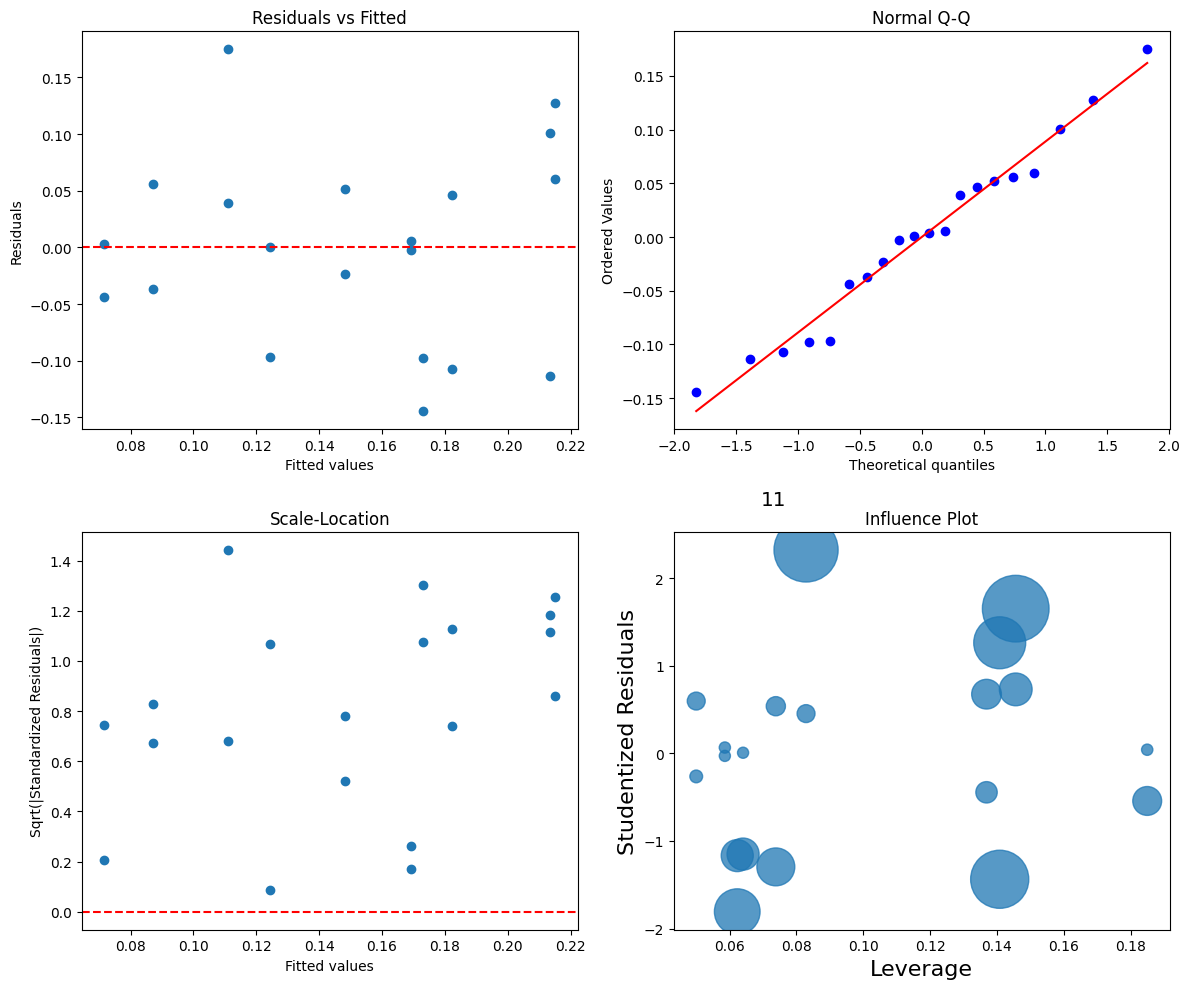

In [8]:
fitted_vals = model.fittedvalues
residuals = model.resid

# Extract fitted values and residuals
fitted_vals = model.fittedvalues
residuals = model.resid
standardized_residuals = model.get_influence().resid_studentized_internal
sqrt_abs_resid = np.sqrt(np.abs(standardized_residuals))

# Create 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axs[0, 0].scatter(fitted_vals, residuals)
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_xlabel("Fitted values")
axs[0, 0].set_ylabel("Residuals")
axs[0, 0].set_title("Residuals vs Fitted")

# 2. Normal Q-Q
stats.probplot(residuals, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Normal Q-Q")

# 3. Scale-Location
axs[1, 0].scatter(fitted_vals, sqrt_abs_resid)
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_xlabel("Fitted values")
axs[1, 0].set_ylabel("Sqrt(|Standardized Residuals|)")
axs[1, 0].set_title("Scale-Location")

# 4. Influence Plot (Cook's Distance)
sm.graphics.influence_plot(model, ax=axs[1, 1], criterion="cooks")
axs[1, 1].set_title("Influence Plot")

plt.tight_layout()
plt.show()

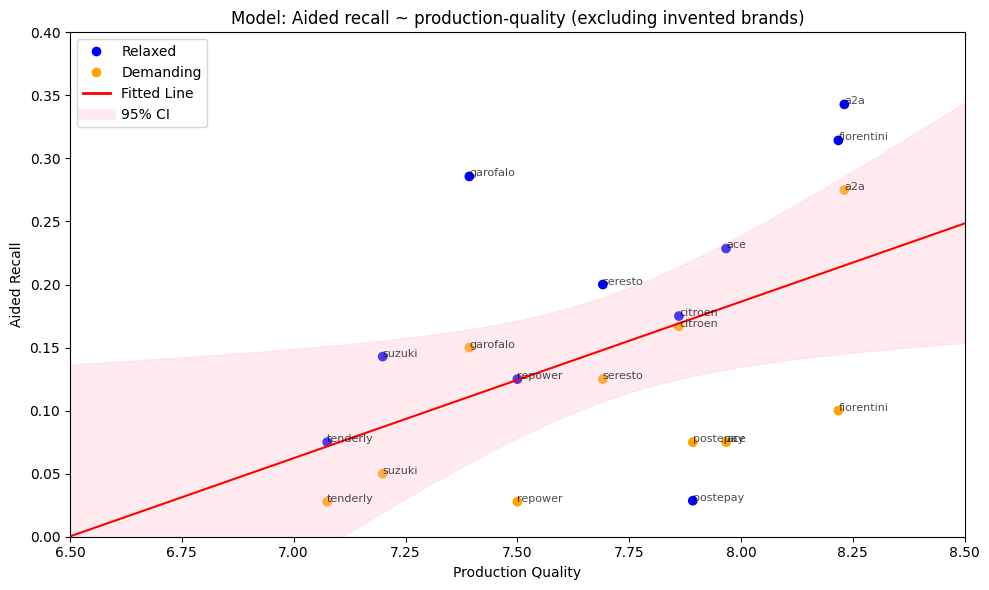

In [9]:
# Create predictor grid for smooth line
X_pred = np.linspace(6, 9, 100)  # Force range 0 to 10
X_pred_const = sm.add_constant(X_pred)

# Get prediction and confidence intervals
predictions = model.get_prediction(X_pred_const)
pred_summary = predictions.summary_frame(alpha=0.05)

# Color mapping
color_map = {'relaxed': 'blue', 'demanding': 'orange'}
colors = df_filtered['condition'].map(color_map)

plt.figure(figsize=(10, 6))

# Scatter plot with colors
plt.scatter(X['production-quality'], y, c=colors, label="Observed")

# Annotate each point with brand
for i, row in df_filtered.iterrows():
    plt.annotate(row['brand'], (row['production-quality'], row['aided']), fontsize=8, alpha=0.7)

# Plot regression line
plt.plot(X_pred, pred_summary['mean'], color="red", label="Fitted Line")

# Plot confidence interval
plt.fill_between(X_pred, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color="pink", alpha=0.3, label="95% CI")

plt.xlabel("Production Quality")
plt.ylabel("Aided Recall")
plt.title("Model: Aided recall ~ production-quality (excluding invented brands)")

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Relaxed', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Demanding', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], color='red', lw=2, label='Fitted Line'),
    Line2D([0], [0], color='pink', lw=8, alpha=0.3, label='95% CI')
]
plt.legend(handles=legend_elements)

# Set x-axis limits
plt.xlim(6.5, 8.5)
plt.ylim(0, 0.4)

plt.tight_layout()
plt.show()

## Model 2: Aided recall ~ content-enjoyment:production-complexity + Is-Demanding

In [32]:
import statsmodels.api as sm

# & (df['is-invented-brand'] != 1)

# Filter out records where exclude_flag == 1
df_filtered = df[(df['exclude_flag'] != 1)] 

# Create interaction terms
df_filtered['content-usefulness:production-quality'] = df_filtered['content-usefulness'] * df_filtered['production-quality']

# Define independent variables (X) and dependent variable (y)
X = df_filtered[['content-usefulness', 
                 'production-quality', 
                 'content-usefulness:production-quality',
                 'is-demanding',
                 ]]
y = df_filtered['aided']

# Add constant to X for intercept
X = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Display regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  aided   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     8.045
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           0.000569
Time:                        15:35:25   Log-Likelihood:                 34.266
No. Observations:                  24   AIC:                            -58.53
Df Residuals:                      19   BIC:                            -52.64
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

C:\Users\forti\AppData\Local\Temp\ipykernel_25472\3858980564.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['content-usefulness:production-quality'] = df_filtered['content-usefulness'] * df_filtered['production-quality']


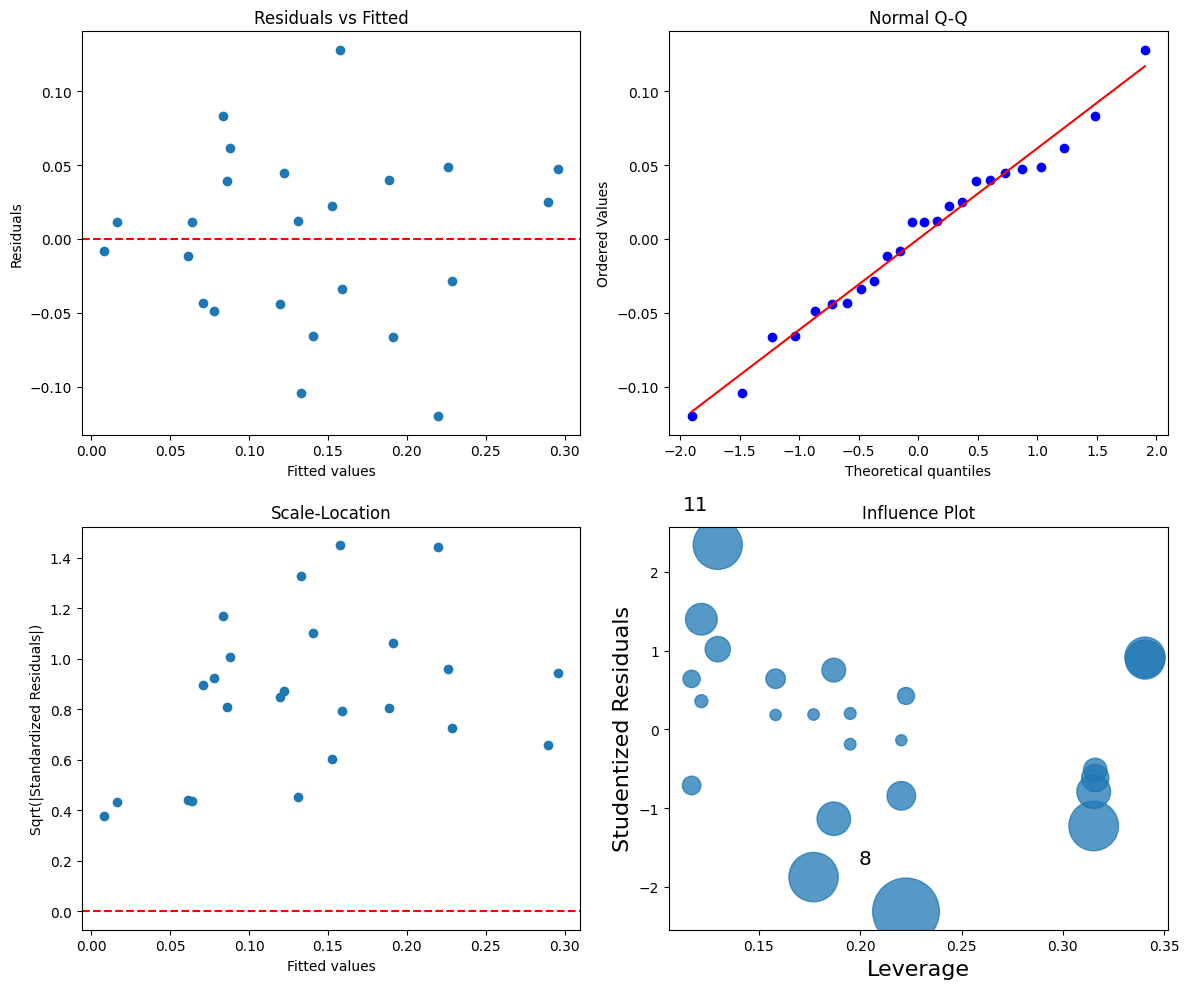

In [12]:
fitted_vals = model.fittedvalues
residuals = model.resid

# Extract fitted values and residuals
fitted_vals = model.fittedvalues
residuals = model.resid
standardized_residuals = model.get_influence().resid_studentized_internal
sqrt_abs_resid = np.sqrt(np.abs(standardized_residuals))

# Create 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axs[0, 0].scatter(fitted_vals, residuals)
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_xlabel("Fitted values")
axs[0, 0].set_ylabel("Residuals")
axs[0, 0].set_title("Residuals vs Fitted")

# 2. Normal Q-Q
stats.probplot(residuals, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Normal Q-Q")

# 3. Scale-Location
axs[1, 0].scatter(fitted_vals, sqrt_abs_resid)
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_xlabel("Fitted values")
axs[1, 0].set_ylabel("Sqrt(|Standardized Residuals|)")
axs[1, 0].set_title("Scale-Location")

# 4. Influence Plot (Cook's Distance)
sm.graphics.influence_plot(model, ax=axs[1, 1], criterion="cooks")
axs[1, 1].set_title("Influence Plot")

plt.tight_layout()
plt.show()

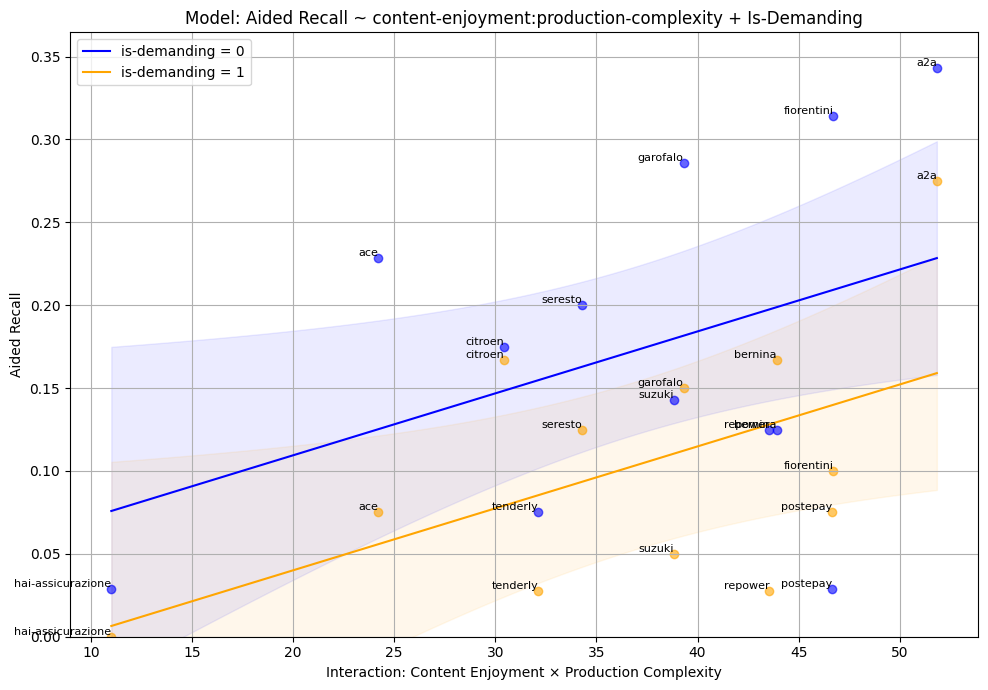

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Filter dataset
df_filtered = df[df['exclude_flag'] != 1].copy()

# Create interaction term
df_filtered['interaction'] = df_filtered['content-enjoyment'] * df_filtered['production-complexity']

# Prepare data
X = sm.add_constant(df_filtered[['interaction', 'is-demanding']])
y = df_filtered['aided']
model = sm.OLS(y, X).fit()

# Prediction grid
interaction_range = np.linspace(df_filtered['interaction'].min(), 
                                df_filtered['interaction'].max(), 100)

fig, ax = plt.subplots(figsize=(10, 7))
for demand_val, color in zip([0, 1], ['blue', 'orange']):
    X_pred = pd.DataFrame({
        'const': 1.0,
        'interaction': interaction_range,
        'is-demanding': demand_val
    })
    preds = model.get_prediction(X_pred).summary_frame(alpha=0.05)
    ax.plot(interaction_range, preds['mean'], label=f'is-demanding = {demand_val}', color=color)
    ax.fill_between(interaction_range, preds['mean_ci_lower'], preds['mean_ci_upper'], 
                    color=color, alpha=0.08)

# Scatter points with brand labels
for _, row in df_filtered.iterrows():
    ax.scatter(row['interaction'], row['aided'], 
               color='blue' if row['is-demanding'] == 0 else 'orange', alpha=0.6)
    ax.text(row['interaction'], row['aided'], row['brand'], fontsize=8, ha='right', va='bottom')

# Aesthetics
ax.set_xlabel('Interaction: Content Enjoyment × Production Complexity')
ax.set_ylabel('Aided Recall')
ax.set_title('Model: Aided Recall ~ content-enjoyment:production-complexity + Is-Demanding')
ax.set_ylim(bottom=0)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## Model 3: Unaided recall ~ content-enjoyment:production-complexity

In [14]:
import statsmodels.api as sm

# & (df['is-invented-brand'] != 1)

# Filter out records where exclude_flag == 1
df_filtered = df[(df['exclude_flag'] != 1)] 

# Create interaction terms
df_filtered['content-enjoyment:production-complexity'] = df_filtered['content-enjoyment'] * df_filtered['production-complexity']

# Define independent variables (X) and dependent variable (y)
X = df_filtered[['content-enjoyment', 
                 'production-complexity', 
                 'content-enjoyment:production-complexity',
                 ]]
y = df_filtered['unaided']

# Add constant to X for intercept
X = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Display regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                unaided   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     2.885
Date:                Wed, 11 Jun 2025   Prob (F-statistic):             0.0612
Time:                        10:04:51   Log-Likelihood:                 35.299
No. Observations:                  24   AIC:                            -62.60
Df Residuals:                      20   BIC:                            -57.89
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

C:\Users\forti\AppData\Local\Temp\ipykernel_25472\3168122440.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['content-enjoyment:production-complexity'] = df_filtered['content-enjoyment'] * df_filtered['production-complexity']


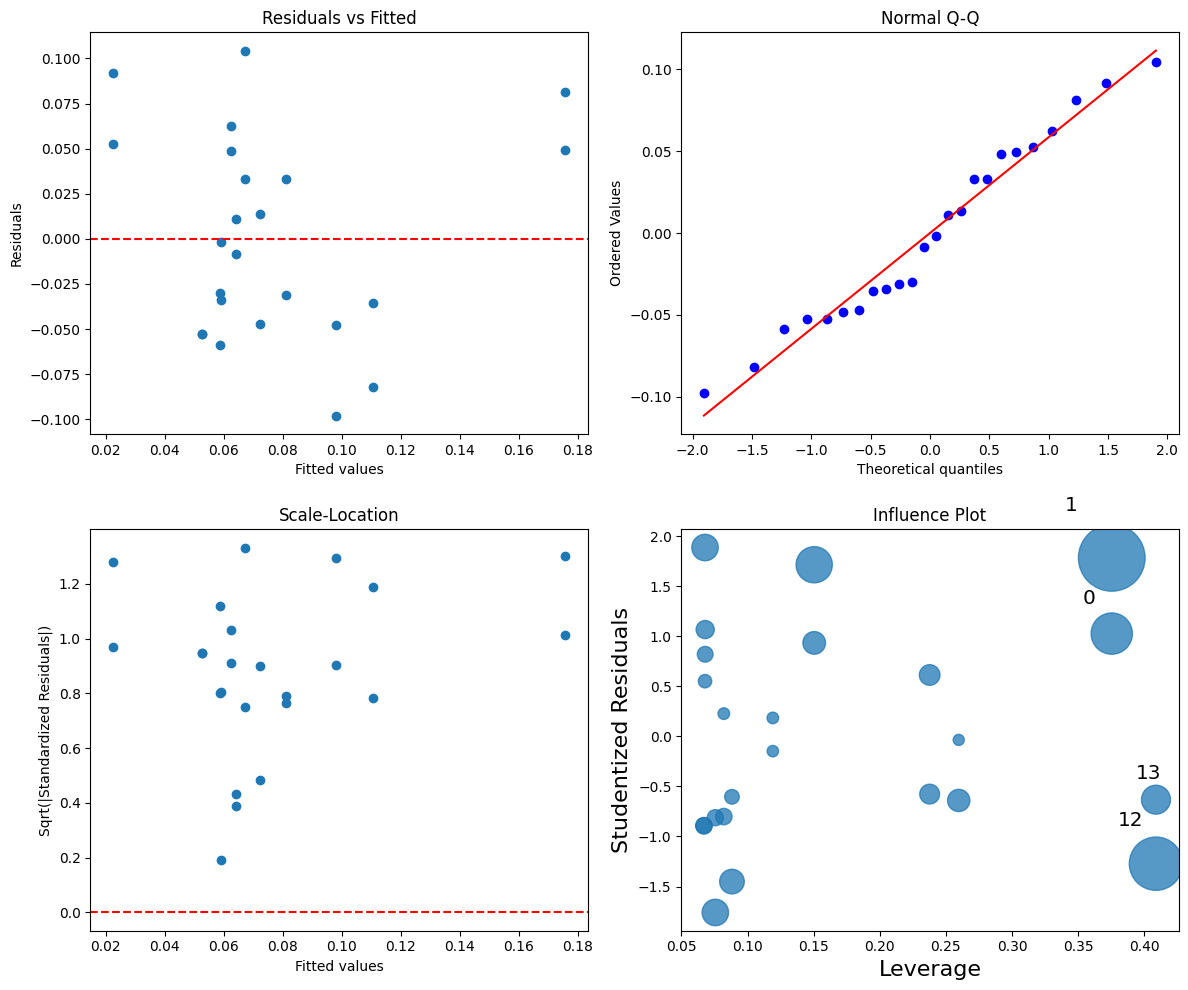

In [15]:
fitted_vals = model.fittedvalues
residuals = model.resid

# Extract fitted values and residuals
fitted_vals = model.fittedvalues
residuals = model.resid
standardized_residuals = model.get_influence().resid_studentized_internal
sqrt_abs_resid = np.sqrt(np.abs(standardized_residuals))

# Create 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axs[0, 0].scatter(fitted_vals, residuals)
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_xlabel("Fitted values")
axs[0, 0].set_ylabel("Residuals")
axs[0, 0].set_title("Residuals vs Fitted")

# 2. Normal Q-Q
stats.probplot(residuals, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Normal Q-Q")

# 3. Scale-Location
axs[1, 0].scatter(fitted_vals, sqrt_abs_resid)
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_xlabel("Fitted values")
axs[1, 0].set_ylabel("Sqrt(|Standardized Residuals|)")
axs[1, 0].set_title("Scale-Location")

# 4. Influence Plot (Cook's Distance)
sm.graphics.influence_plot(model, ax=axs[1, 1], criterion="cooks")
axs[1, 1].set_title("Influence Plot")

plt.tight_layout()
plt.show()

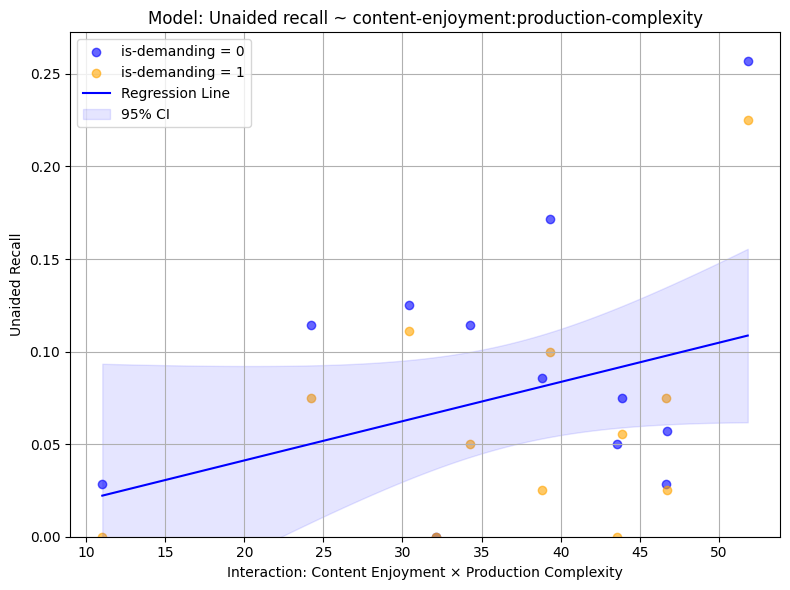

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Filter dataset
df_filtered = df[df['exclude_flag'] != 1].copy()

# Create interaction term
df_filtered['interaction'] = df_filtered['content-enjoyment'] * df_filtered['production-complexity']

# Fit model: unaided ~ interaction
X = sm.add_constant(df_filtered[['interaction']])
y = df_filtered['unaided']
model = sm.OLS(y, X).fit()

# Create prediction space
interaction_range = np.linspace(df_filtered['interaction'].min(), 
                                df_filtered['interaction'].max(), 100)
X_pred = sm.add_constant(pd.DataFrame({'interaction': interaction_range}))
preds = model.get_prediction(X_pred).summary_frame(alpha=0.05)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
# Color map for is-demanding
colors = df_filtered['is-demanding'].map({0: 'blue', 1: 'orange'})
labels = df_filtered['is-demanding'].map({0: 'Not Demanding', 1: 'Demanding'})

# Plot colored scatter points
for class_val in [0, 1]:
    mask = df_filtered['is-demanding'] == class_val
    ax.scatter(df_filtered.loc[mask, 'interaction'], 
               df_filtered.loc[mask, 'unaided'], 
               alpha=0.6, 
               color='blue' if class_val == 0 else 'orange', 
               label=f'is-demanding = {class_val}')
ax.plot(interaction_range, preds['mean'], color='blue', label='Regression Line')
ax.fill_between(interaction_range, preds['mean_ci_lower'], preds['mean_ci_upper'], 
                color='blue', alpha=0.1, label='95% CI')

# Labels
ax.set_xlabel('Interaction: Content Enjoyment × Production Complexity')
ax.set_ylabel('Unaided Recall')
ax.set_title('Model: Unaided recall ~ content-enjoyment:production-complexity')
ax.set_ylim(bottom=0)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Logistic regression

## Model 4

In [59]:
import statsmodels.api as sm

# Create interaction term
df_granular['content-usefulness:production-quality'] = df_granular['content-usefulness'] * df_granular['production-quality']

# Define independent variables (X) and target variable (y)
X = df_granular[['content-usefulness', 'production-quality', 'content-usefulness:production-quality', 'is-demanding', 'knew-the-ad']]
y = df_granular['aided']

# Add constant for intercept
X = sm.add_constant(X)

# Fit logistic regression model
model = sm.Logit(y, X).fit()

# Display summary
print(model.summary())

         Current function value: 0.302280
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  aided   No. Observations:                  904
Model:                          Logit   Df Residuals:                      898
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.2400
Time:                        18:15:24   Log-Likelihood:                -273.26
converged:                      False   LL-Null:                       -359.57
Covariance Type:            nonrobust   LLR p-value:                 2.023e-35
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    25.4060     18.041      1.408      0.159      -9.

c:\GitHub\audio-aesthetics\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Machine learning models

## Random forest classifier

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Define features and target
features = [
    'brand',
    'content-enjoyment',
    'content-usefulness',
    'production-complexity',
    'production-quality',
    'is-demanding',
    'is-playlist',
    'is-invented-brand',
    'knew-the-ad'
]
target = 'aided'

X = df_granular[features]
y = df_granular[target]

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Preprocessing: One-hot encode categorical, scale numeric
categorical_features = ['brand']
numeric_features = [
    'content-enjoyment',
    'content-usefulness',
    'production-complexity',
    'production-quality'
]
binary_features = ['is-demanding', 'is-playlist', 'is-invented-brand', 'knew-the-ad']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numeric_features),
    ('bin', 'passthrough', binary_features)
])

# 4. Define model pipeline
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 5. Train model
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[103  55]
 [  9  14]]
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       158
           1       0.20      0.61      0.30        23

    accuracy                           0.65       181
   macro avg       0.56      0.63      0.53       181
weighted avg       0.83      0.65      0.70       181



## XGBoost

In [67]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# 1. Define features and target
features = [
    'brand',
    'content-enjoyment',
    'content-usefulness',
    'production-complexity',
    'production-quality',
    'is-demanding',
    'is-playlist',
    'is-invented-brand',
    'knew-the-ad'
]
target = 'aided'

X = df_granular[features]
y = df_granular[target]

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Preprocessing
categorical_features = ['brand']
numeric_features = [
    'content-enjoyment',
    'content-usefulness',
    'production-complexity',
    'production-quality'
]
binary_features = ['is-demanding', 'is-playlist', 'is-invented-brand', 'knew-the-ad']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numeric_features),
    ('bin', 'passthrough', binary_features)
])

# 4. Compute scale_pos_weight for imbalance
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 5. Define XGBoost pipeline
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False,
                                 eval_metric='logloss',
                                 scale_pos_weight=pos_weight,
                                 random_state=42))
])

# 6. Fit model
model.fit(X_train, y_train)

# 7. Evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


c:\GitHub\audio-aesthetics\env\lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[103  55]
 [  9  14]]
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       158
           1       0.20      0.61      0.30        23

    accuracy                           0.65       181
   macro avg       0.56      0.63      0.53       181
weighted avg       0.83      0.65      0.70       181

